# Project 4

## Group Number 6

### Team Members
- Baraa Nidal Ghannoum
- Tom Mantel
- Mubarik Omar Ali Abdi


Abstract:
The main purpose of project 4 is to understand and apply supervised and unsupervised machine learning into scientifical applications such as analysis of astronomical cluster images, and the study of epidemiology.

Topic 1 dwelss on unsupervised learning through the use of the milky way cluster image. By converting the sky map imgaes into numerical RGB arrays (red, green, and blue pixels). One can observe through different clustering techniques how a galaxy is structured.

Topic 2 involves supervised learning by creating a model of the ebola outbreak. Several predictive methods are implimented such as linear regression, neural network (NN), and LSTM architecture. These methods are meant to further the understanding on how an outbreak like Ebola can further evolve.


Intro:
Machine learning is a tool used in relation with artificial intelligience, by creating algorithms which have the ability to adapt to patterns based on established data [1]. The application of machine learning is a new method for data analysts to understand complex systems, and develop usefull models or predicting future outcomes. In todays world, the more traditional method of analytical techniques does not always bring accurate results.

In the field of AI, machine learning has already become a resourceful tool for occupations like weather forecasting, to production of self driven vechiles [1]. Project 4 involves how supervised and unsupervised machine learning can be applied in regards of mapping of celestial vodies to predicting the evolution of an epidemic.

Topic 1

Task 0

In [34]:
# Task 0: Install mw_plot library
!pip install mw_plot


ERROR: Could not install packages due to an OSError: [WinError 5] Ingen tilgang: 'c:\\users\\mubarik\\anaconda3\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Created wheel for mw-plot: filename=mw_plot-0.11.1-py3-none-any.whl size=33617084 sha256=f51e90414a26fb96d640fcdd700bdf890736a3508363cee843fdc22a69abae6f
  Stored in directory: c:\users\mubarik\appdata\local\pip\cache\wheels\8e\b5\a5\9810f3fa5faac9893442bc90ad137ff70f1501a6a20165b326
Successfully built mw-plot
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:


In [35]:
import mw_plot
print("mw_plot successfully installed and imported!")
#to make srure the library is installed and working, we can run a simple command


ModuleNotFoundError: No module named 'mw_plot'

Task 1

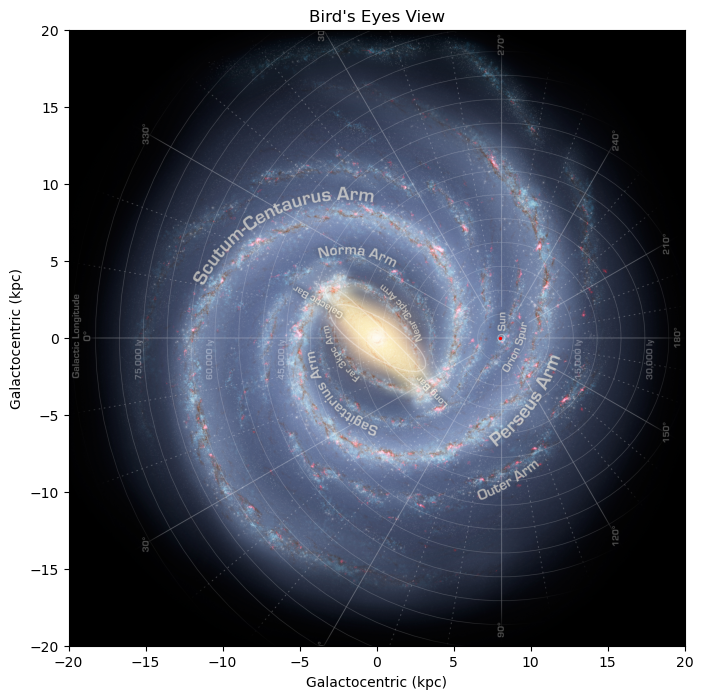

In [ ]:
# Task 1: Create a simple plot using mw_plot
import numpy as np
from astropy import units as u
from mw_plot import MWFaceOn

mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)


mw1.title = "Bird's Eyes View"
mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)


Task 2

As we need to measure the brightness of the galaxy at different radiuses, we go to data reduction, aka 2-D to 1-D curves. We convert the RGB into luminance, and convert the pixel positions to galactrocenctric coordinates, which should in the end showcase a graph coresponding brightness vs radius.

In [ ]:
# Task 2: building the visualizations

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from mw_plot import MWFaceOn
from matplotlib.colors import rgb_to_hsv

def render_faceon(radius=20*u.kpc, figsize=(10,8)):
    fig = plt.figure(figsize=figsize, dpi=150)
    mw = MWFaceOn(radius=radius, unit=u.kpc, coord="galactrocenctric",
                  annotation=True, figsize=figsize)
    mw.title = "Eyes view of the galaxy"
    mw.scatter(8*u.kpc, 0*u.kpc, c="r", s=2)

    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = buf.reshape(h, w, 3)
    plt.close(fig)
    return img, (-radius.value, radius.value, -radius.value, radius.value)  # extended with kpc

def radial_profile_sector(rgb, extent, center=(0,0), rmax=12.0, nrbins=60,
                          theta_deg=(0, 360)):
    # colour -> grayscale
    lum = (0.2126*rgb[...,0] + 0.7152*rgb[...,1] + 0.0722*rgb[...,2]).astype(float)

    xmin, xmax, ymin, ymax = extent
    h, w = lum.shape
    xs = np.linspace(xmin, xmax, w)
    ys = np.linspace(ymin, ymax, h)
    X, Y = np.meshgrid(xs, ys)

    xc, yc = center
    R = np.sqrt((X-xc)**2 + (Y-yc)**2)
    T = (np.degrees(np.arctan2(Y-yc, X-xc)) + 360) % 360

    t1, t2 = theta_deg
    if t1 <= t2:
        sector = (T>=t1) & (T<=t2)
    else:
        sector = (T>=t1) | (T<=t2)

    r_edges = np.linspace(0, rmax, nrbins+1)
    prof = np.zeros(nrbins)
    for i in range(nrbins):
        mask = (R>=r_edges[i]) & (R<r_edges[i+1]) & sector
        prof[i] = lum[mask].mean() if np.any(mask) else np.nan
    r_centers = 0.5*(r_edges[:-1] + r_edges[1:])
    return r_centers, prof

# rendering the image once
rgb_array, extent = render_faceon(radius=20*u.kpc)

# three different profiles (different centers, radiuses, sectors)
configs = [
    {"center":(0,0),   "rmax":15, "theta_deg":(0,360),  "label":"center (0,0), full ring"},
    {"center":(2,0),   "rmax":12, "theta_deg":(30,120), "label":"center (2,0) kpc, 30–120°"},
    {"center":(-4,3),  "rmax":10, "theta_deg":(200,320),"label":"center (-4,3) kpc, 200–320°"},
]

plt.figure(dpi=120)
for cfg in configs:
    r, y = radial_profile_sector(rgb_array, extent, **cfg)
    plt.plot(r, y, marker=".", label=cfg["label"])
plt.xlabel("Radius (kpc)")
plt.ylabel("Mean luminance (arb.)")
plt.title("Milky Way radial profiles in sectors (Task 2)")
plt.legend()
plt.show()

Task 3

We will capture and render figures directly from matplotlib, and it will return a numpy array representing the image.

In [ ]:
# Do note that we need the rgb array to be named as rgb_array for the code to work

#calling the renderer from task 2 into the code

rgb_array, extent = render_faceon(radius=20*u.kpc)
print(rgb_array.shape, rgb_array.dtype)

Task 4

Each RGB channel (0–255) is broken into 4 ranges

Every pixel gets mapped to a category number (0 to 63)

In [ ]:
# A

def color_bins(rgb, k=4):
    # rgb is advised to be in the uint8 format.
    bins = np.linspace(0, 256, k+1)
    r = np.digitize(rgb[...,0], bins) - 1
    g = np.digitize(rgb[...,1], bins) - 1
    b = np.digitize(rgb[...,2], bins) - 1
    #this is combined into a single integer label
    labels = (r * k + g) * k + b
    return labels

labels_bins = color_bins(rgb_array, k=4)  # categories per channel

Task 5

In [ ]:
# Task 5: Apply K-means clustering to Milky Way image data

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume 'rgb_array' is the numpy array from Task 3 til  i get ur stuff 
# Shape: (height, width, 3)

# Flatten the image into a 2D array of pixels
pixels = rgb_array.reshape(-1, 3)

# Choose number of clusters (e.g., 3 categories: red, grey, dark)
n_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(pixels)

# Get cluster labels for each pixel
labels = kmeans.labels_

# Reshape labels back to image shape
clustered_image = labels.reshape(rgb_array.shape[0], rgb_array.shape[1])

# Visualize the clustered result
plt.imshow(clustered_image, cmap="viridis")
plt.title("Clustered Milky Way Image (Task 5)")
plt.axis("off")
plt.show()


NameError: name 'rgb_array' is not defined

Task 6

build a colour for each cluster from its centroid, better than randomly assigning colours to each cluster because:
If you color each cluster with a random color (e.g. cyan, pink, neon green):

-cluster 0 might represent the dark background, but appear red
-cluster 1 might represent the bright bulge, but appear black
-cluster 2 might represent the blue spiral arms, but appear yellow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

centroids = kmeans.cluster_centers_.astype(np.uint8)     # shaping (K,3)
palette   = centroids

seg_rgb = palette[clustered_image]                       # (H,W,3) uint8

alpha = 0.5                                              
overlay = (alpha*seg_rgb + (1-alpha)*rgb_array).astype(np.uint8)

plt.figure(figsize=(12,4), dpi=120)
plt.subplot(1,3,1); plt.imshow(rgb_array);   plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(seg_rgb);     plt.title("Clusters colorized"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay);     plt.title("Overlay (Task 6)");   plt.axis("off")
plt.show()

Task 7



We will compare the results from task 4 using intertia and solhouette scores. This allows us to understand how the galaxy's structure appear at different clustering levels, and will help us determine a reasonable number of clusters for segmentation.

In [ ]:
# Task 7: Evaluate K-means clustering with inertia and silhouette scores

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

H, W, _ = rgb_array.shape
pixels = rgb_array.reshape(-1,3).astype(float)
idx = np.random.choice(pixels.shape[0], size=min(50_000, pixels.shape[0]), replace=False)
sample = pixels[idx] / 255.0

Ks = [2,3,4,5,6]
inertias, sils = [], []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto")
    km.fit(sample)
    inertias.append(km.inertia_)
    # silhouette needs >=2 clusters and all points should not be identical
    try:
        sils.append(silhouette_score(sample, km.predict(sample)))
    except Exception:
        sils.append(np.nan)

plt.figure(dpi=120)
plt.plot(Ks, inertias, marker="o"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow (Task 7)")
plt.show()

plt.figure(dpi=120)
plt.plot(Ks, sils, marker="o"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette vs K (Task 7)")
plt.show()

for K in [3,5]:
    km = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(pixels/255.0)
    seg = km.labels_.reshape(H, W)
    seg_rgb = (km.cluster_centers_*255).astype(np.uint8)[seg]
    overlay = (0.5*seg_rgb + 0.5*rgb_array).astype(np.uint8)

    plt.figure(figsize=(8,3), dpi=120)
    plt.subplot(1,2,1); plt.imshow(seg_rgb); plt.title(f"K={K} clusters"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"K={K} overlay");  plt.axis("off")
    plt.show()

Topic 2

Task 0:

The following model is replicated from project 2 exercise 5 for plotting Ebola outbreak

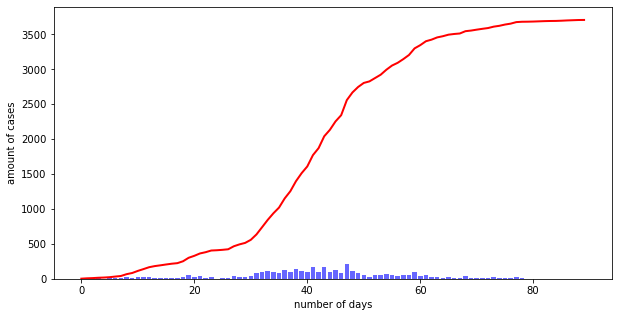

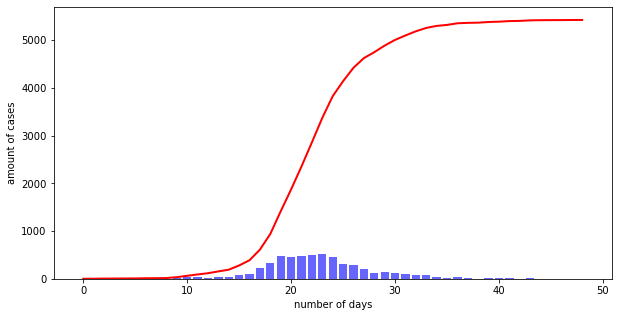

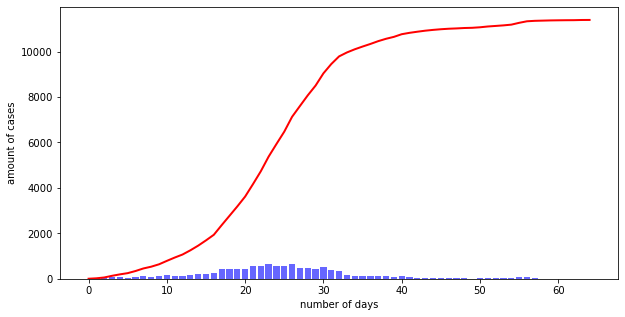

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#list of country data files 

data_files = {
    "Guinea" : "ebola_models/ebola_cases_guinea.dat",
    "Liberia" : "ebola_models/ebola_cases_liberia.dat",
    "Sierra Leone" : "ebola_models/ebola_cases_sierra_leone.dat"
} 

#loop through each country's data file to generate plots 
for country, file in data_files.items():
    #load the data
    data = file
    try:
         new_cases = np.loadtxt(file, usecols=2)
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue    

    #calculate the cumulative number of cases 

    cumulative_cases= np.cumsum(new_cases)

    #create a time array in days
    time_days = np.arange(len(new_cases))


    #creat the plot, ensure to label axes and add a legend

    plt.figure(figsize=(10, 5))

    #plot new cases as bars 
    plt.bar(time_days, new_cases, label='New Cases', alpha=0.6, color='blue')
    #plot cumulative cases as a line
    plt.plot(time_days, cumulative_cases, label='Cumulative Cases', color='red', linewidth=2)
    plt.xlabel('number of days')
    plt.ylabel('amount of cases')   
    


The first graph shows the number of cases of ebola reported in Guinea, with the x-axis representing the number of days, and the y-axis showing the amount of cases. The second graph showcases Liberia, while the third shows Sierra Leone. 

Task 1:

We will train up an algorithm to use linear regression method on the data of the three countiress. Linear regression is one of the most used methods for modelling the relation between multiple variables [2]. 

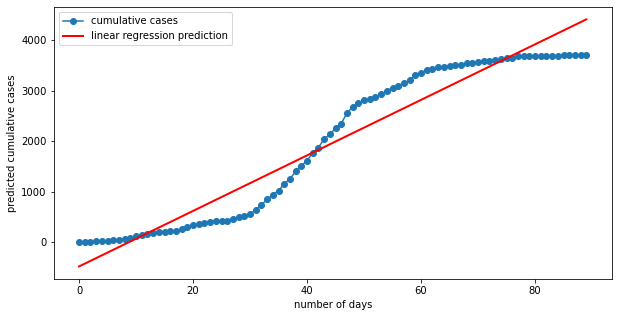

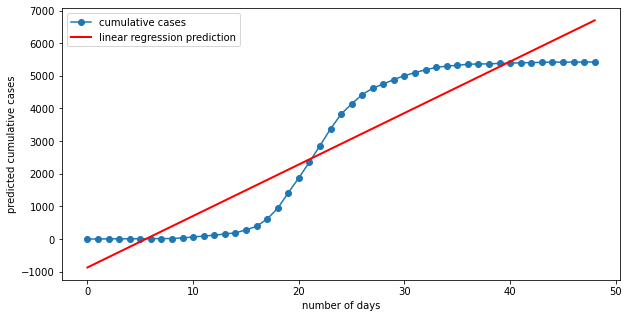

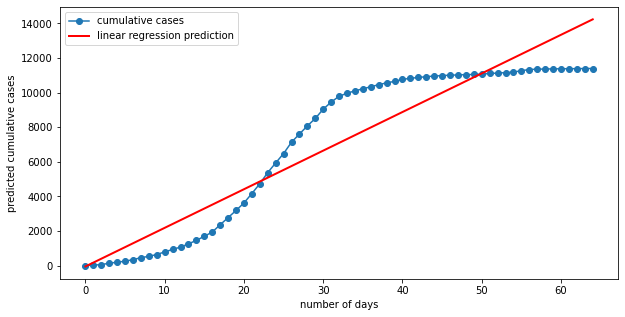

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt

# provide data to work with
data_files = {
    "Guinea" : "ebola_models/ebola_cases_guinea.dat",
    "Liberia" : "ebola_models/ebola_cases_liberia.dat",
    "Sierra Leone" : "ebola_models/ebola_cases_sierra_leone.dat"
} 

cumulative_data = {} # Dictionary for cumulative cases
#loop through each country's data file to generate plots 
for country, file in data_files.items():
    #load the data
    data = file
    try:
         new_cases = np.loadtxt(file, usecols=2)
         cumulative_data[country] = np.cumsum(new_cases) 
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue


for country, cumulative_cases in cumulative_data.items():

  x = np.arange(len(cumulative_cases)).reshape((-1, 1))
  y = cumulative_cases

# create a regression model and fit it with existing data.
  model = LinearRegression()
  model.fit(x, y)

  y_pred = model.predict(x) # Prediction of cumulative cass

  plt.figure(figsize=(10,5))
  plt.plot(x, y, label='cumulative cases', marker='o')
  plt.plot(x, y_pred, label='linear regression prediction', color='red', linewidth=2)
  plt.xlabel('number of days')
  plt.ylabel('predicted cumulative cases')
  plt.legend()
  plt.show


Task 2:

The method we will implement is the polynomial regression technique, which is more fitting for analysing complex system like the evoultion of the epidemic outbreak [3]. Where as linear regression is more suitable for variables with linear relations. 

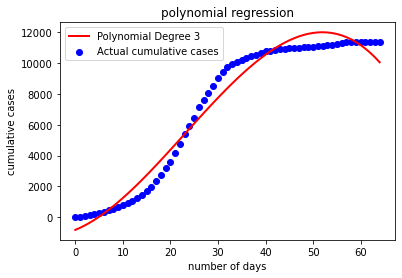

In [ ]:
import numpy as np
import matplotlib
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

data_files = {
    "Guinea" : "ebola_models/ebola_cases_guinea.dat",
    "Liberia" : "ebola_models/ebola_cases_liberia.dat",
    "Sierra Leone" : "ebola_models/ebola_cases_sierra_leone.dat"
} 

cumulative_data = {}

for country, file in data_files.items():
    #load the data
    data = file
    try:
         new_cases = np.loadtxt(file, usecols=2)
         cumulative_data[country] = np.cumsum(new_cases) 
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue

for country, cumulative_cases in cumulative_data.items():

  x = np.arange(len(cumulative_cases)).reshape((-1, 1))
  y = cumulative_cases
 

# creating a polynomial regression model and training it:
degree = 3
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(x, y)
y_poly_pred = poly_model.predict(x)

plt.scatter(x, y, color='blue', label='Actual cumulative cases')
plt.plot(x, y_poly_pred, color='red', linewidth=2, label=f'Polynomial Degree {degree}')
plt.xlabel('number of days')
plt.ylabel('cumulative cases')
plt.title('polynomial regression')
plt.legend()
plt.show()


Task 3:


In [ ]:
# We will be adding libraires like sklearn model for dividing the data for training and testing, and tensorflow. 

import numpy as np
import matplotlib as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

data_files = {
    "Guinea" : "ebola_models/ebola_cases_guinea.dat",
    "Liberia" : "ebola_models/ebola_cases_liberia.dat",
    "Sierra Leone" : "ebola_models/ebola_cases_sierra_leone.dat"
} 

cumulative_data = {}

for country, file in data_files.items():
    #load the data
    data = file
    try:
         new_cases = np.loadtxt(file, usecols=2)
         cumulative_data[country] = np.cumsum(new_cases) 
    except FileNotFoundError:
            print(f"File {file} not found. Skipping {country}.")
            continue
    
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue

for country, cumulative_cases in cumulative_data.items():

  x = np.arange(len(cumulative_cases)).reshape((-1, 1))
  y = cumulative_cases



ModuleNotFoundError: No module named 'tensorflow'

Task 4:

Task 5:

Self Reflection:

Conclusion: 

Usage of AI: ChatGPT was used as a guideline to solve task 2 of topic 2

References:

[1] https://www.ibm.com/think/topics/machine-learning

[2] https://realpython.com/linear-regression-in-python/#linear-regression

[3] https://www.kaggle.com/code/lxlz1986/polynomial-regression-in-scikit-learn
